In [1]:
from autograd import grad, hessian
import autograd.numpy as np
from scipy.stats import gaussian_kde
import math

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:

class Model(object):
    def __init__(self, x_info, s_info, num_draws):
        self.x_info = x_info
        self.s_info = s_info
        self.s_draws = np.random.normal(loc=0, scale=1 / np.sqrt(s_info), size=num_draws)
        self.std_draws = np.random.normal(size=num_draws)
        self.x_draws = None
        self.x_dens = None

    def mean_func(self, s, theta):
        return theta * s ** 2
        
    def log_prob_x_given_s(self, x, s, theta):
        return -0.5 * self.x_info * (x - self.mean_func(s, theta))**2 + 0.5 * np.log(self.x_info) - np.log(2 * math.pi)
     
    def log_prob_s(self, s):
        return -0.5 * self.s_info * (s**2) + 0.5 * np.log(self.s_info)  - np.log(2 * math.pi)
    
    def log_joint(self, s, x, theta):
        lik =  self.log_prob_x_given_s(x, s, theta) + self.log_prob_s(s)
        #print lik
        return lik
    
    def simulate_x(self, theta):
        self.x_draws = self.std_draws / np.sqrt(self.x_info) + model.mean_func(self.s_draws, theta)
        self.x_dens = gaussian_kde(self.x_draws)
        
    def log_prob(self, theta, x_obs):
        self.simulate_x(theta)
        return model.x_dens.logpdf(x_obs)

        

In [3]:
from scipy.stats import norm
from scipy.optimize import minimize

model = Model(x_info=10., s_info=1., num_draws=1000)

x_obs = 10.
theta = 1 / (x_obs * model.s_info)
s = 0.1

log_joint_grad = grad(model.log_joint)
log_joint_hess = hessian(model.log_joint)

print np.matrix(log_joint_hess(s, x_obs, theta))

std_draws = norm.ppf(np.arange(0.001, 0.999, 0.001))

def get_s_given_x(theta, x_obs):
#     s_opt_result = \
#      minimize(lambda s: -1 * model.log_joint(s, x_obs, theta), s, method='dogleg',
#               jac=lambda s: -1 * log_joint_grad(s, x_obs, theta),
#               hess=lambda s: np.matrix(-1 * log_joint_hess(s, x_obs, theta)),
#               options={'disp': False})

    s_opt_result = \
     minimize(lambda s: -1 * model.log_joint(s, x_obs, theta), s, method='Nelder-Mead',
              options={'disp': False})

    s_opt = s_opt_result.x[0]
    d = log_joint_hess(s_opt, x_obs, theta)

    if not s_opt_result.success:
        print 'Theta = %f, x_obs = %f' % (theta, x_obs)
        print s_opt_result
    
    assert s_opt_result.success
    assert d < 0

    return s_opt, 1 / (-d)


def get_s_draws_given_x(theta, x_obs):
    s_opt, s_var = get_s_given_x(theta, x_obs)
    s_draws = std_draws * np.sqrt(s_var) + s_opt
    return s_draws

    
def m_step(theta, s_draws, x_obs):
    theta_opt_result = \
        minimize(lambda theta: -1 * np.mean(model.log_prob_x_given_s(x_obs, s_draws, theta)),
                 theta,
                 method='Nelder-Mead')
    assert theta_opt_result.success
    return theta_opt_result.x[0]

theta_old = theta
diff = float('inf')

# You probably need more iters
max_iters = 500
iteration = 0
while diff > 1e-8 and iteration < max_iters:
    iteration += 1
    s_draws = get_s_draws_given_x(theta_old, x_obs)
    theta_new = m_step(theta_old, s_draws, x_obs)
    diff = np.abs(theta_new - theta_old)
    print 'Theta: %f   Diff: %f    Iter: %d' % (theta_new, diff, iteration)
    theta_old = theta_new

print 'Done:'
print('Maximizer: ', theta_new)


[[ 18.994]]
Theta: 0.105117   Diff: 0.005117    Iter: 1
Theta: 0.110250   Diff: 0.005133    Iter: 2
Theta: 0.115332   Diff: 0.005082    Iter: 3
Theta: 0.120377   Diff: 0.005046    Iter: 4
Theta: 0.125456   Diff: 0.005078    Iter: 5
Theta: 0.130553   Diff: 0.005097    Iter: 6
Theta: 0.135601   Diff: 0.005049    Iter: 7
Theta: 0.140633   Diff: 0.005032    Iter: 8
Theta: 0.145632   Diff: 0.004999    Iter: 9
Theta: 0.150638   Diff: 0.005006    Iter: 10
Theta: 0.155640   Diff: 0.005002    Iter: 11
Theta: 0.160626   Diff: 0.004985    Iter: 12
Theta: 0.165582   Diff: 0.004957    Iter: 13
Theta: 0.170563   Diff: 0.004980    Iter: 14
Theta: 0.175493   Diff: 0.004930    Iter: 15
Theta: 0.180429   Diff: 0.004936    Iter: 16
Theta: 0.185362   Diff: 0.004934    Iter: 17
Theta: 0.190286   Diff: 0.004924    Iter: 18
Theta: 0.195192   Diff: 0.004906    Iter: 19
Theta: 0.200072   Diff: 0.004880    Iter: 20
Theta: 0.204917   Diff: 0.004845    Iter: 21
Theta: 0.209800   Diff: 0.004883    Iter: 22
Theta: 

Theta: 0.976136   Diff: 0.003893    Iter: 198
Theta: 0.980045   Diff: 0.003908    Iter: 199
Theta: 0.983969   Diff: 0.003924    Iter: 200
Theta: 0.987812   Diff: 0.003844    Iter: 201
Theta: 0.991671   Diff: 0.003859    Iter: 202
Theta: 0.995545   Diff: 0.003874    Iter: 203
Theta: 0.999433   Diff: 0.003889    Iter: 204
Theta: 1.003337   Diff: 0.003904    Iter: 205
Theta: 1.007257   Diff: 0.003919    Iter: 206
Theta: 1.011093   Diff: 0.003836    Iter: 207
Theta: 1.014944   Diff: 0.003851    Iter: 208
Theta: 1.018809   Diff: 0.003866    Iter: 209
Theta: 1.022690   Diff: 0.003880    Iter: 210
Theta: 1.026485   Diff: 0.003795    Iter: 211
Theta: 1.030344   Diff: 0.003859    Iter: 212
Theta: 1.034168   Diff: 0.003824    Iter: 213
Theta: 1.038005   Diff: 0.003838    Iter: 214
Theta: 1.041857   Diff: 0.003852    Iter: 215
Theta: 1.045724   Diff: 0.003866    Iter: 216
Theta: 1.049553   Diff: 0.003830    Iter: 217
Theta: 1.053345   Diff: 0.003792    Iter: 218
Theta: 1.057151   Diff: 0.003806  

Theta: 1.684735   Diff: 0.003120    Iter: 401
Theta: 1.687779   Diff: 0.003044    Iter: 402
Theta: 1.690828   Diff: 0.003049    Iter: 403
Theta: 1.693883   Diff: 0.003055    Iter: 404
Theta: 1.696943   Diff: 0.003060    Iter: 405
Theta: 1.700009   Diff: 0.003066    Iter: 406
Theta: 1.703080   Diff: 0.003071    Iter: 407
Theta: 1.706157   Diff: 0.003077    Iter: 408
Theta: 1.709239   Diff: 0.003082    Iter: 409
Theta: 1.712327   Diff: 0.003088    Iter: 410
Theta: 1.715421   Diff: 0.003094    Iter: 411
Theta: 1.718436   Diff: 0.003015    Iter: 412
Theta: 1.721457   Diff: 0.003021    Iter: 413
Theta: 1.724483   Diff: 0.003026    Iter: 414
Theta: 1.727514   Diff: 0.003031    Iter: 415
Theta: 1.730551   Diff: 0.003037    Iter: 416
Theta: 1.733593   Diff: 0.003042    Iter: 417
Theta: 1.736640   Diff: 0.003047    Iter: 418
Theta: 1.739693   Diff: 0.003053    Iter: 419
Theta: 1.742751   Diff: 0.003058    Iter: 420
Theta: 1.745814   Diff: 0.003063    Iter: 421
Theta: 1.748798   Diff: 0.002984  

0.980521601888
0.437845414034


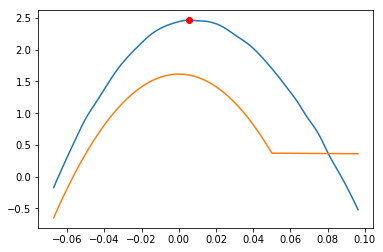

In [7]:
# Look directly at the putative maginals.

def get_uros_log_prob(model, theta, x_obs):
    s_opt, s_var = get_s_given_x(theta, x_obs)
    return model.log_prob_x_given_s(x_obs, s_opt, theta) + 0.5 * np.log(s_var)

model = Model(x_info=1000., s_info=1., num_draws=100000)

theta = 0.01
model.simulate_x(theta)    
x_grid = np.linspace(np.percentile(model.x_draws, 100 * 0.01), np.percentile(model.x_draws, 100 * 0.99), 100)
x_log_prob = model.x_dens.logpdf(x_grid)
uros_x_log_prob = [ get_uros_log_prob(model, theta, x) for x in x_grid ]

# Sanity check the density.
delta_x = x_grid[1] - x_grid[0]
print np.sum(delta_x * np.exp(x_log_prob))
print np.sum(delta_x * np.exp(uros_x_log_prob))

plt.plot(x_grid, x_log_prob)
plt.plot(x_grid, uros_x_log_prob)

x_max_ind = np.argmax(x_log_prob)
x_obs = x_grid[x_max_ind]
plt.plot(x_obs, x_log_prob[x_max_ind], 'ro')
